In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment_DDPG 
# from vehicle_model_ECMS_2 import Environment_ECMS  
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

In [2]:
driving_cycle_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
driving_cycle = sio.loadmat(driving_cycle_path)
driving_cycle = driving_cycle["sch_cycle"][:, 1]
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
driver = Driver_MDP(0.02) 

num_states = 4 

In [3]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    
    
actor_model = get_actor() 

In [4]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [9]:
def test_model(cycle, model_path): 
#     test_cycle = driver.get_cycle() 
#     env_ECMS = Environment_ECMS(cell_model, cycle, battery_path, motor_path)
#     history_ECMS = env_ECMS.PMP_calculation(EF)
#     print(history_ECMS)
    
    env_DDPG = Environment_DDPG(cell_model, cycle, battery_path, motor_path, 10) 
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env_DDPG.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env_DDPG.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env_DDPG.history["SOC"]) - 0.6)) 
    history_DDPG = env_DDPG.history 
    print("******************* Test is start *****************")
#     print(test_cycle)
#     print(history_ECMS["SOC_traj"][-1])
#     print(env_DDPG.fuel_consumption)
    print("total reward = {:.3f}".format(total_reward))
    print("final SOC for DDPG: {:.4f}".format(history_DDPG["SOC"][-1]))
    print("FC for DDPG: {:.4f}".format(env_DDPG.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(history_ECMS["SOC_traj"], linewidth=2, label="SOC trajectory for ECMS") 
#     plt.plot(history_DDPG["SOC"], linewidth=2, label="SOC trajectory for DDPG")
    
#     plt.grid() 
#     plt.xlabel("Time[s]", fontsize=14)
#     plt.ylabel("SOC", fontsize=14)
#     plt.legend()
#     plt.savefig("DDPG_PMP_comparison.png")
    return total_reward, history_DDPG 

In [11]:
test_cycles = glob.glob("../data/driving_cycles/test/*.mat")
rewards_one = [] 
actor_one = "./DDPG_reference_trained_variant_one/actor_model.h5"
for test_cycle in test_cycles: 
    print(test_cycle)
    driving_cycle = sio.loadmat(test_cycle)
    driving_cycle = driving_cycle["sch_cycle"][:, 1]
    total_reward, _ = test_model(driving_cycle, actor_one)
    rewards_one.append(total_reward)


../data/driving_cycles/test\00_nedc.mat


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -122.349
final SOC for DDPG: 0.6144
FC for DDPG: 47.3558
******************* Test is done *****************

../data/driving_cycles/test\cudec_freeway.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -99.155
final SOC for DDPG: 0.6035
FC for DDPG: 54.2425
******************* Test is done *****************

../data/driving_cycles/test\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -53.399
final SOC for DDPG: 0.5969
FC for DDPG: 8.8296
******************* Test is done *****************

../data/driving_cycles/test\ny_city_traffic.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -29.829
final SOC for DDPG: 0.5979
FC for DDPG: 4.4505
******************* Test is done **************

In [13]:
test_cycles = glob.glob("../data/driving_cycles/test/*.mat")
rewards_five = [] 
actor_five = "./DDPG_reference_trained_variant_five/actor_model.h5"
for test_cycle in test_cycles: 
    print(test_cycle)
    driving_cycle = sio.loadmat(test_cycle)
    driving_cycle = driving_cycle["sch_cycle"][:, 1]
    total_reward, _ = test_model(driving_cycle, actor_five)
    rewards_five.append(total_reward)

../data/driving_cycles/test\00_nedc.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -89.016
final SOC for DDPG: 0.6179
FC for DDPG: 47.9510
******************* Test is done *****************

../data/driving_cycles/test\cudec_freeway.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -86.551
final SOC for DDPG: 0.6069
FC for DDPG: 55.1188
******************* Test is done *****************

../data/driving_cycles/test\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -27.593
final SOC for DDPG: 0.5990
FC for DDPG: 9.0694
******************* Test is done *****************

../data/driving_cycles/test\ny_city_traffic.mat
maximum steps, simulation is done ... 
******************* Test is start *****************
total reward = -15.076
final SOC for DDPG: 0.6029
FC for DDPG: 4.9407
********

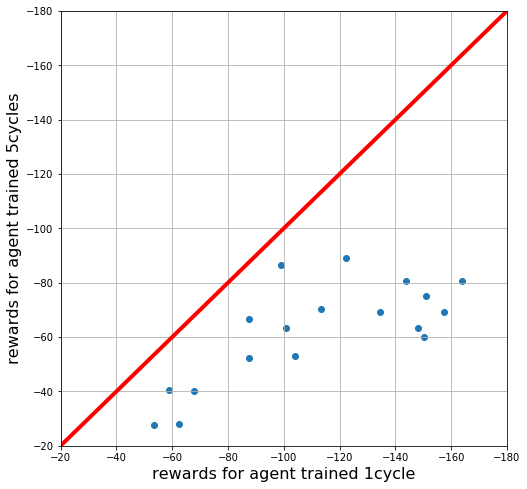

In [22]:
plt.figure(figsize=(8, 8))
plt.plot([-20, -40, -60, -100, -200], [-20, -40, -60, -100, -200], "r", linewidth=4)
plt.scatter(rewards_one, rewards_five)
plt.xlim([-20, -180])
plt.ylim([-20, -180])
plt.grid() 
plt.xlabel("rewards for agent trained 1cycle", fontsize=16)
plt.ylabel("rewards for agent trained 5cycles", fontsize=16)

plt.savefig("generalization_comparison.png")